# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [30]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.emfiles import load_data,crop_fourier_images
from src.jaxops import *
from src.fsc import *
import jax

import mrcfile

plt.rcParams["figure.figsize"]=8,8

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
star_file = "Extract/job020/particles.star"

imgs_f, params = load_data(data_dir, star_file)
ctf_params = params["ctf_params"]
pixel_size = params["pixel_size"]
angles = params["angles"]
shifts = params["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


load_data: number of partcles:  5090
load_data: data loaded, time:  5.140915155410767
load_data: FFT of data, time:  9.588788270950317


(5090, 256, 256)
(5090,)
(5090, 3)
(5090, 2)
(5090, 9)


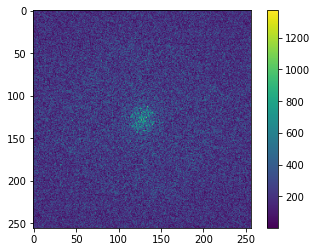

In [4]:
print(imgs_f.shape)
print(pixel_size.shape)
print(angles.shape)
print(shifts.shape)
print(ctf_params.shape)

plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101]))); plt.colorbar()

### Only keep the first N points (to avoid out of memory error)

In [5]:
N = 1000
imgs_f = imgs_f[:1000]
pixel_size = pixel_size[:1000]
angles = angles[:1000]
shifts = shifts[:1000]
ctf_params = ctf_params[:1000]

### Create the grids

In [6]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873214e-03 2.56000000e+02]


### Crop images to 64 x 64 

In [7]:
nx = 128
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873214e-03 1.28000000e+02]


### Before further processing, vectorize the images, create mask etc

In [8]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(1000, 16384)


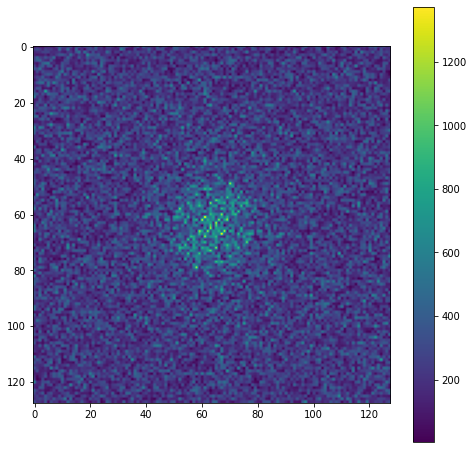

In [40]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

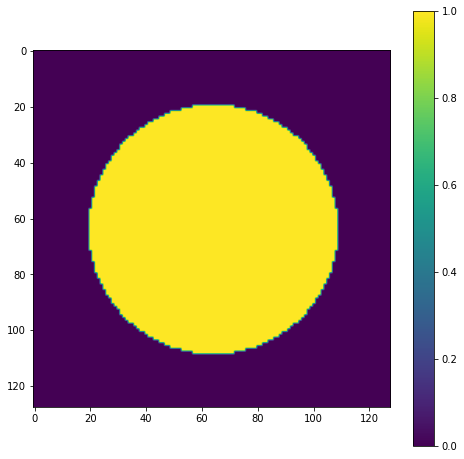

In [41]:
centre = (0,0,0)
#radius = 0.07 # for nx=64
radius = 0.14 # for nx=128

mask = create_3d_mask(x_grid, centre, radius)


mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Forward model and loss functon

In [11]:
alpha = 0.1

slice_func,slice_func_array = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum = get_loss_funcs(slice_func, alpha = alpha)

grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

Test the functions above with a random volume

In [12]:
vf = jnp.array(np.random.randn(nx,nx,nx))
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(16384,)

In [13]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0])
print(time.time()-start)
print(ll.shape)

1.150895118713379
(128, 128, 128)


In [14]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx])
print(time.time()-start)
print(ll.shape)

1.5737967491149902
(128, 128, 128)


### CG

In [15]:
from src.algorithm import conjugate_gradient, get_cg_vol_ops

#v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 50

AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles, shifts, ctf_params, imgs_f, v0.shape)

vcg, max_iter = conjugate_gradient(AA, Ab, v0, N_iter, verbose = True)

Iter 0 ||r|| = 0.0047808477378362075
Iter 1 ||r|| = 0.0005258410605574262
Iter 2 ||r|| = 0.00018387670849499452
Iter 3 ||r|| = 0.00028357963456209856
Iter 4 ||r|| = 0.00021677673671486886
Iter 5 ||r|| = 0.00011942531396822872
Iter 6 ||r|| = 2.8081965490618384e-05
Iter 7 ||r|| = 4.705042155359915e-05
Iter 8 ||r|| = 8.810795389909776e-05
Iter 9 ||r|| = 9.719823199984884e-05
Iter 10 ||r|| = 0.00010446800990097182
Iter 11 ||r|| = 0.00010996233979991949
Iter 12 ||r|| = 0.00011360384638312456
Iter 13 ||r|| = 0.00011530086631401217
Iter 14 ||r|| = 0.00011501091003236394
Iter 15 ||r|| = 0.00011277132717092606
Iter 16 ||r|| = 0.0001087039418031671
Iter 17 ||r|| = 0.00010299818447297239
Iter 18 ||r|| = 9.587755820393356e-05
Iter 19 ||r|| = 8.755534770543566e-05
Iter 20 ||r|| = 7.818821122630278e-05
Iter 21 ||r|| = 6.784870130034343e-05
Iter 22 ||r|| = 5.6588531930133696e-05
Iter 23 ||r|| = 4.4813028044643335e-05
Iter 24 ||r|| = 3.424350472895578e-05
Iter 25 ||r|| = 2.8224727536798262e-05
Iter 26

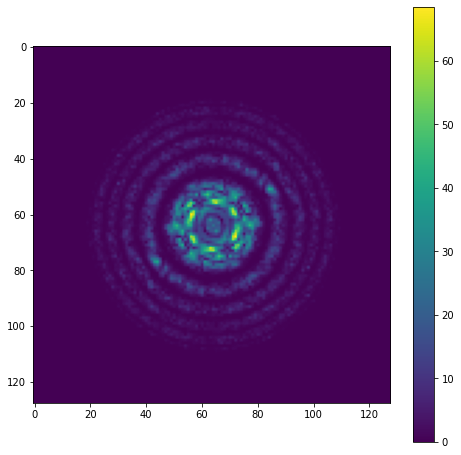

In [39]:
i = 110
s0 = slice_func(vcg, angles[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

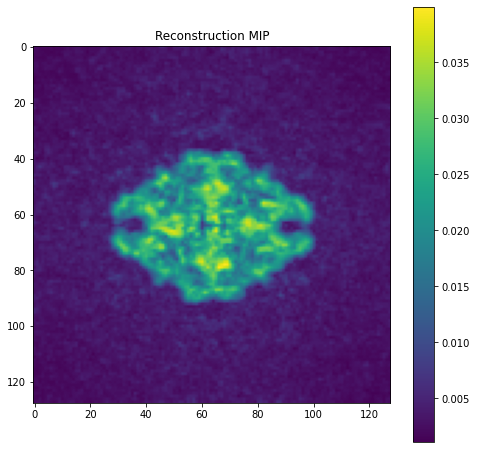

In [38]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [18]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg))) 

In [19]:
vr.shape

(128, 128, 128)

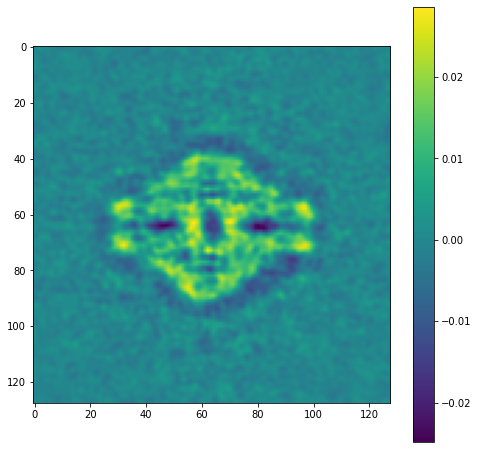

In [37]:
plt.imshow(vr[:,:,64]); plt.colorbar()

### Write volume to file

In [21]:
#with mrcfile.new('../data/reconstruction_c.mrc', overwrite=True) as mrc:
#    mrc.set_data(vr.astype(np.float32))

### Orientations, standard deviation for each voxel etc

In [22]:
points_v_tri = points_orientations_tri(angles, x_grid[1])

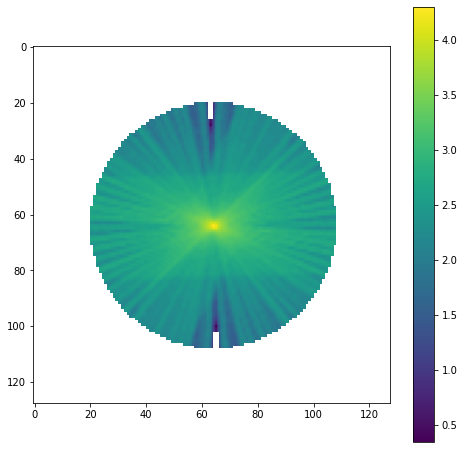

In [31]:
plt.imshow(jnp.log(jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

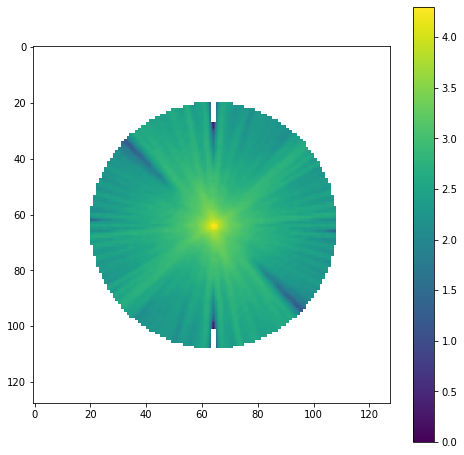

In [32]:
plt.imshow(jnp.log(jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

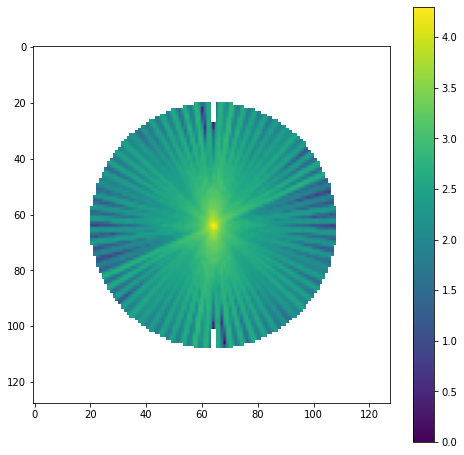

In [33]:
plt.imshow(jnp.log(jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [26]:
vones = jnp.ones(vcg.shape)
omega = AA(vones)
omega = 1/omega

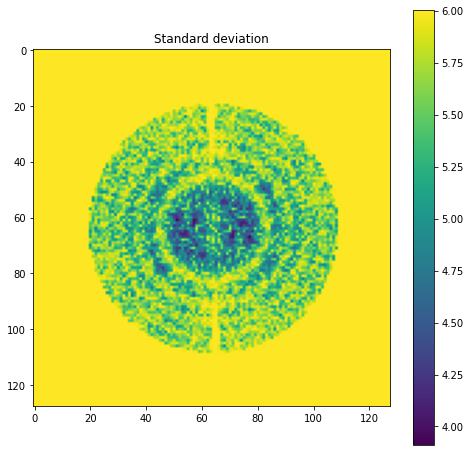

In [34]:
plt.title("Standard deviation")
plt.imshow(jnp.log(jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

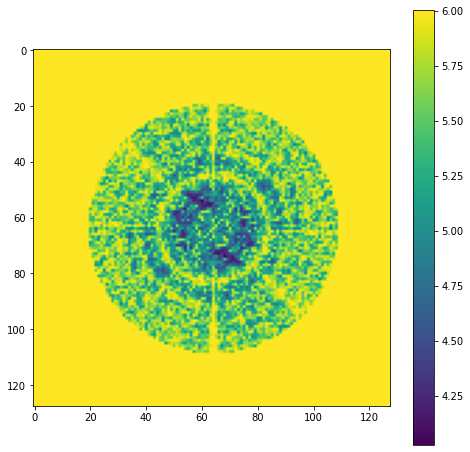

In [35]:
plt.imshow(jnp.log(jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))))); plt.colorbar()

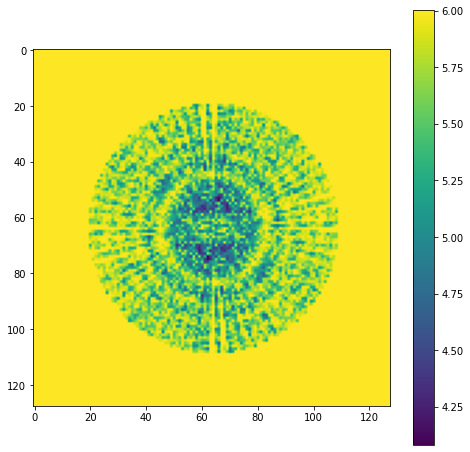

In [36]:
plt.imshow(jnp.log(jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))))); plt.colorbar()